# Classification of the Data

## Data Loading and preparation

/tmp/ipykernel_134605/1641517098.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[column] = (df_train[column] - df_train[column].mean())/df_train[column].std()
/tmp/ipykernel_134605/1641517098.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val[column] = (df_val[column] - df_val[column].mean())/df_val[column].std()
/tmp/ipykernel_134605/1641517098.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

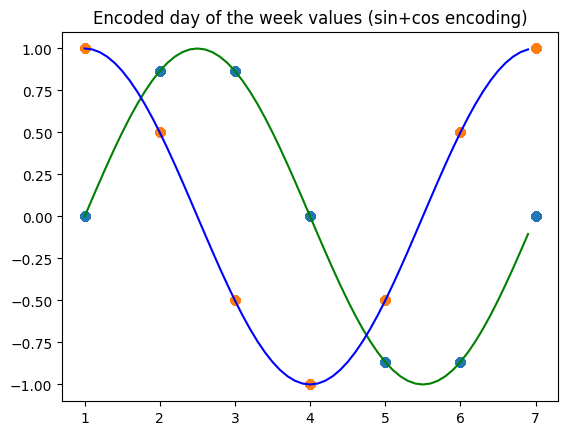

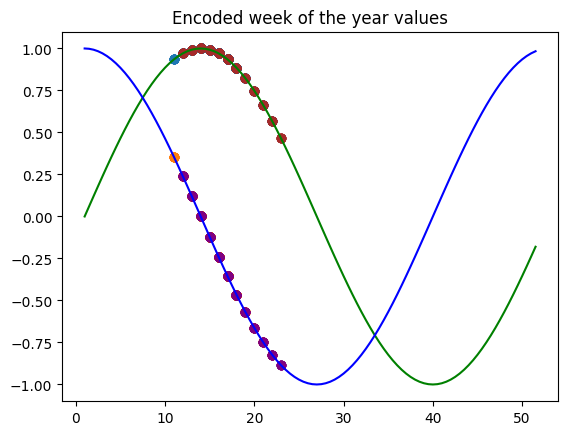

In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
import random


n_classes = 10
# data
X_features = [
    "mood","arousal","valence","activity","screen",
    "call","sms", "day_sin", "day_cos", "day_year_sin", "day_year_cos", "appCat_total", "appCat.builtin", "appCat.communication",
    "appCat.entertainment", "appCat.finance", "appCat.game", "appCat.office",
    "appCat.social", "appCat.travel", "appCat.unknown", "appCat.utilities", "appCat.weather", "night_screen", "SUM_inactivity_timediff"
]
Y_features = [
    "mood_of_next_day"
]
df_data = pd.read_csv("./data/data_4_aggregated_day_TRAINSET.csv")
df_data["datetime"] = pd.to_datetime(df_data["datetime"])

df_test = pd.read_csv("./data/data_4_aggregated_day_TESTSET.csv")
df_test["datetime"] = pd.to_datetime(df_test["datetime"])


df_train = pd.DataFrame()
df_val = pd.DataFrame()

random.seed(42)
ids = df_data["id"].unique()
val_subjects = set(random.choices(ids, k=int(0.2*len(ids))))
ids = set(ids)
train_subjects = ids.difference(val_subjects)

df_val = df_data[df_data["id"].isin(val_subjects)]
df_train = df_data[df_data["id"].isin(train_subjects)]

#for subject_id in df_data["id"].unique():
#    df_subject = df_data[df_data["id"]==subject_id]
#
#    df_subject = df_subject.sort_values(by="datetime")
#    split_index = int(0.8 * len(df_subject))
#    #subject_test_indices = TimeSeriesSplit(n_splits=2, test_size=len(df_subject)*0.2).split(df_subject)
#    df_train = pd.concat([df_train, df_subject.iloc[:split_index]])
#    df_val = pd.concat([df_val, df_subject.iloc[split_index:]])


for column in ["screen", "call","sms",*X_features[11:]]:
    df_train[column] = (df_train[column] - df_train[column].mean())/df_train[column].std()
    df_val[column] = (df_val[column] - df_val[column].mean())/df_val[column].std()
    df_test[column] = (df_test[column] - df_test[column].mean())/df_test[column].std()

min_c, max_c = -2, 2
for column in ["arousal", "valence"]:
    df_train[column] = (df_train[column] - min_c) / (max_c - min_c)
    df_val[column] = (df_val[column] - min_c) / (max_c - min_c)
    df_test[column] = (df_test[column] - min_c) / (max_c - min_c)

for column in ["mood", "mood_of_next_day"]:
    df_train[column] = df_train[column].round(0)
    df_val[column] = df_val[column].round(0)
    df_test[column] = df_test[column].round(0)

# add week and day sin cos features
for df_tmp in [df_train, df_val, df_test]:
    df_tmp["day_sin"] = df_tmp["weekday"].apply(lambda x: np.sin((x-1)*(2*np.pi/6)))
    df_tmp["day_cos"] = df_tmp["weekday"].apply(lambda x: np.cos((x-1)*(2*np.pi/6)))
    df_tmp["day_year_sin"] = df_tmp["datetime"].dt.isocalendar().week.apply(lambda x: np.sin((x-1)*(2*np.pi/52)))
    df_tmp["day_year_cos"] = df_tmp["datetime"].dt.isocalendar().week.apply(lambda x: np.cos((x-1)*(2*np.pi/52)))

#df_test["day_sin"] = df_test["day_of_week"].apply(lambda x: np.sin((x-1)*(2*np.pi/6)))
#df_test["day_cos"] = df_test["day_of_week"].apply(lambda x: np.cos((x-1)*(2*np.pi/6)))

#df_train["day_year_sin"] = df_train["datetime"].dt.isocalendar().week.apply(lambda x: np.sin((x-1)*(2*np.pi/52)))
#df_train["day_year_cos"] = df_train["datetime"].dt.isocalendar().week.apply(lambda x: np.cos((x-1)*(2*np.pi/52)))
#df_test["day_year_sin"] = df_test["datetime"].dt.isocalendar().week.apply(lambda x: np.sin((x-1)*(2*np.pi/52)))
#df_test["day_year_cos"] = df_test["datetime"].dt.isocalendar().week.apply(lambda x: np.cos((x-1)*(2*np.pi/52)))

x = np.arange(2, 8, 0.1)
x = x-1
y = np.sin((x-1)*(2*np.pi/6))
y_cos = np.cos((x-1)*(2*np.pi/6))
# Plotting Sine Graph
plt.plot(x, y, color='green')
plt.plot(x, y_cos, color="blue")
plt.scatter(np.array(df_train["weekday"]), np.array(df_train["day_sin"]))
plt.scatter(np.array(df_train["weekday"]), np.array(df_train["day_cos"]))

plt.title("Encoded day of the week values (sin+cos encoding)")
plt.show()

x = np.arange(1, 52, 0.5)
y = np.sin((x-1)*(2*np.pi/52))
y_cos = np.cos((x-1)*(2*np.pi/52))

plt.plot(x, y, color='green')
plt.plot(x, y_cos, color="blue")
plt.scatter(np.array(df_train["datetime"].dt.isocalendar().week), np.array(df_train["day_year_sin"]))
plt.scatter(np.array(df_train["datetime"].dt.isocalendar().week), np.array(df_train["day_year_cos"]))

plt.scatter(np.array(df_test["datetime"].dt.isocalendar().week), np.array(df_test["day_year_sin"]), color="brown")
plt.scatter(np.array(df_test["datetime"].dt.isocalendar().week), np.array(df_test["day_year_cos"]), color="purple")
plt.title("Encoded week of the year values")
plt.show()


### Windowing

In [27]:
from windowing import WindowGenerator

df_classification_train = df_train.copy()
df_classification_val = df_val.copy()
df_classification_test = df_test.copy()


for df in [df_classification_train, df_classification_val, df_classification_test]:
    df.loc[df["mood"]<=6, "mood"] = 1
    df.loc[df["mood"]==7, "mood"] = 2
    df.loc[df["mood"]>7, "mood"] = 3
    df.loc[df["mood_of_next_day"]<=6, "mood_of_next_day"] = 1
    df.loc[df["mood_of_next_day"]==7, "mood_of_next_day"] = 2
    df.loc[df["mood_of_next_day"]>7, "mood_of_next_day"] = 3
 

w_mood_classification = WindowGenerator(
  input_width=7,
  label_width=0, 
  expected_window_length=7,
  label_column=Y_features[0], 
  feature_columns=X_features,
  df_train=df_classification_train,
  df_val=df_classification_val,
  df_test=df_classification_test,
  num_classes=3,
  datetime_label="datetime",
)

X_train_classification, Y_train_classification = w_mood_classification.train
X_validation_classification, Y_validation_classification = w_mood_classification.val
X_test_classification, Y_test_classification = w_mood_classification.test

print(X_train_classification.shape, Y_train_classification.shape)
print(X_validation_classification.shape, Y_validation_classification.shape)
print(X_test_classification.shape, X_test_classification.shape)
print(Y_train_classification)

Original sample: 776, windowed data points: 650
Original sample: 153, windowed data points: 125
Original sample: 221, windowed data points: 186
(650, 7, 25) (650, 3)
(125, 7, 25) (125, 3)
(186, 7, 25) (186, 7, 25)
tf.Tensor(
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]], shape=(650, 3), dtype=float32)


### Beep classification Data

In [28]:
w_mood_classification_beep = WindowGenerator(
  input_width=1,
  label_width=1, 
  expected_window_length=5,
  label_column="mood", 
  feature_columns=X_features,
  df_train=df_classification_train,
  df_val=df_classification_val,
  df_test=df_classification_test,
  num_classes=3,
  datetime_label="datetime",
)

X_train_classification_beep, Y_train_classification_beep = w_mood_classification_beep.train
X_validation_classification_beep, Y_validation_classification_beep = w_mood_classification_beep.val
X_test_classification_beep, Y_test_classification_beep = w_mood_classification_beep.test

print(X_train_classification_beep.shape, Y_train_classification_beep.shape)
print(X_validation_classification_beep.shape, Y_validation_classification_beep.shape)
print(X_test_classification_beep.shape, X_test_classification_beep.shape)

Original sample: 776, windowed data points: 0
Original sample: 153, windowed data points: 0
Original sample: 221, windowed data points: 0
(0, 1, 25) (0, 3)
(0, 1, 25) (0, 3)
(0, 1, 25) (0, 1, 25)


### Regression Data

In [30]:
w_mood_regression = WindowGenerator(
  input_width=7,
  label_width=0,
  expected_window_length=7,
  label_column=Y_features[0], 
  feature_columns=X_features,
  df_train=df_train,
  df_val=df_val,
  df_test=df_test,
  num_classes=10,
  datetime_label="datetime",
  regression=True
)

X_train_regression, Y_train_regression = w_mood_regression.train
X_validation_regression, Y_validation_regression = w_mood_regression.val
X_test_regression, Y_test_regression = w_mood_regression.test

print(X_train_regression.shape, Y_train_regression.shape)
print(X_validation_regression.shape, Y_validation_regression.shape)
print(X_test_regression.shape, Y_test_regression.shape)
print(X_features)
print(X_train_regression[0][0])
print(Y_validation_regression)

/home/m/Desktop/Projects/DMT/windowing.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data["date"] = df_data[self.datetime_label].dt.date


Original sample: 776, windowed data points: 650


/home/m/Desktop/Projects/DMT/windowing.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data["date"] = df_data[self.datetime_label].dt.date


Original sample: 153, windowed data points: 125
Original sample: 221, windowed data points: 186
(650, 7, 25) (650,)
(125, 7, 25) (125,)
(186, 7, 25) (186,)
['mood', 'arousal', 'valence', 'activity', 'screen', 'call', 'sms', 'day_sin', 'day_cos', 'day_year_sin', 'day_year_cos', 'appCat_total', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'night_screen', 'SUM_inactivity_timediff']
[ 7.          0.45        0.8         0.12953212 -0.22154003 -0.6409358
  5.88929915 -0.8660254  -0.5         0.93501624  0.35460489 -0.30690377
 -0.21489347 -0.78854595 -0.46192706 -0.20099104 -0.17629421 -0.18141098
 -0.01779921  6.68564308  1.91469715 -0.08844798 -0.19130064 -0.61257292
  1.63391726]
[7. 8. 7. 6. 6. 6. 7. 7. 6. 7. 7. 7. 7. 7. 7. 8. 7. 7. 7. 7. 7. 8. 7. 8.
 7. 7. 8. 7. 8. 8. 7. 7. 8. 7. 7. 8. 8. 7. 7. 7. 7. 7. 6. 7. 7. 7. 8. 7.
 7. 7.

## Optimization Setup

First we setup the code for optimization

In [31]:
# shared variables in both optimization parts
repetitions = 2
n_classes = 3

### Classification

In [32]:
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential


def get_classification_model(encoding_layers, classification_layers, lstm_units, dropout):
    encoding_layers_list = []
    for i in range(encoding_layers):
        encoding_layers_list += [Dense(2**(5+i), activation="relu"), Dropout(dropout)]

    classification_layers_list = []
    for i in range(classification_layers):
        classification_layers_list += [Dropout(dropout), Dense(2**(5+i), activation="relu")]
    classification_layers_list = classification_layers_list[::-1]
    classification_layers_list = classification_layers_list[:-1]
    LSTM_model = Sequential([
        *encoding_layers_list,
        LSTM(lstm_units),
        *classification_layers_list,
        Dense(n_classes, activation="softmax")
    ])
    return LSTM_model

# function that should be maximized by the bayesian optimization
def train_wrapper_classification(bs: float, lr: float, lstm_units: float, encoding_layers: float, classification_layers: float, dropout: float):
    batch_size = int(bs)
    lstm_units = int(lstm_units)
    encoding_layers = int(encoding_layers)
    classification_layers = int(classification_layers)

    # return negative value to turn a minimization to a maximization problem
    results = [
        -train_network_classification(batch_size, lr, lstm_units, encoding_layers, classification_layers, dropout) for _ in range(repetitions)
    ]
    # average scores
    return sum(results)/len(results)


def train_network_classification(bs: int, lr: float, lstm_units: int, encoding_layers: int, classification_layers: int, dropout: float) -> float:
    
    #print(LSTM_model.summary())
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=150,
        mode='min'
    )
    LSTM_model = get_classification_model(encoding_layers, classification_layers, lstm_units, dropout)
    LSTM_model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=["accuracy", "f1_score"]
    )

    history = LSTM_model.fit(x=X_train_classification, y=Y_train_classification, epochs=1000, batch_size=bs,
                        validation_data=(X_validation_classification, Y_validation_classification),
                        callbacks=[early_stopping],
                        verbose=0)
    # return the lowest validation loss seen
    return min(history.history["val_loss"])
    

### Regression Setup
Now the same for the regression model

In [33]:
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential


def get_regression_model(encoding_layers, regression_layers, lstm_units, dropout):
    encoding_layers_list = []
    for i in range(encoding_layers):
        encoding_layers_list += [Dense(2**(5+i), activation="relu"), Dropout(dropout)]

    regression_layers_list = []
    for i in range(regression_layers):
        regression_layers_list += [Dropout(dropout), Dense(2**(5+i), activation="relu")]
    regression_layers_list = regression_layers_list[::-1]
    regression_layers_list = regression_layers_list[:-1]
    LSTM_model = Sequential([
        *encoding_layers_list,
        LSTM(lstm_units),
        *regression_layers_list,
        Dense(1)
    ])
    return LSTM_model

# function that should be maximized by the bayesian optimization
def train_wrapper_regression(bs: float, lr: float, lstm_units: float, encoding_layers: float, classification_layers: float, dropout: float):
    batch_size = int(bs)
    lstm_units = int(lstm_units)
    encoding_layers = int(encoding_layers)
    classification_layers = int(classification_layers)

    # return negative value to turn a minimization to a maximization problem
    results = [
        -train_network_regression(batch_size, lr, lstm_units, encoding_layers, classification_layers, dropout) for _ in range(repetitions)
    ]
    # average scores
    return sum(results)/len(results)


def train_network_regression(bs: int, lr: float, lstm_units: int, encoding_layers: int, regression_layers: int, dropout: float) -> float:
    #print(LSTM_model.summary())
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=150,
        mode='min'
    )
    LSTM_model = get_regression_model(encoding_layers, regression_layers, lstm_units, dropout)
    LSTM_model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=["mse", "mae"]
    )

    history = LSTM_model.fit(x=X_train_regression, y=Y_train_regression, epochs=1000, batch_size=bs,
                        validation_data=(X_validation_regression, Y_validation_regression),
                        callbacks=[early_stopping],
                        verbose=0)
    # return the lowest validation loss seen
    return min(history.history["val_loss"])
    

## Classification Model

In [34]:
# pip install bayesian-optimization
from bayes_opt import BayesianOptimization


# Bounded region of parameter space
pbounds = {
    'bs': (1, 1000),
    'lr': (0, 0.01),
    "lstm_units": (32, 512),
    "encoding_layers": (1, 4),
    "classification_layers": (1, 4),
    "dropout": (0, 0.6)
}


optimizer = BayesianOptimization(
    f=train_wrapper_classification,
    pbounds=pbounds,
    random_state=1,
)

optimizer.maximize(
    init_points=2,
    n_iter=30,
)

print(optimizer.max)

|   iter    |  target   |    bs     | classi... |  dropout  | encodi... |    lr     | lstm_u... |
-------------------------------------------------------------------------------------------------
| 1         | -0.8939   | 417.6     | 3.161     | 6.862e-05 | 1.907     | 0.001468  | 76.32     |


KeyboardInterrupt: 

### Train Final model

In [36]:
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

bs=417
lr=0.001468
lstm_units=76
encoding_layers=2
classification_layers=3
dropout=0.4


LSTM_model_final = get_classification_model(encoding_layers, classification_layers, lstm_units, dropout)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=200,
    mode='min'
)

save_best_model = ModelCheckpoint(
    './models/classification_mdl_wts.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

LSTM_model_final.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics=["accuracy", "f1_score", "recall", "precision"])
history = LSTM_model_final.fit(
    x=X_train_classification, y=Y_train_classification,
    epochs=2000,
    batch_size=bs,
    validation_data=(X_validation_classification, Y_validation_classification),
    callbacks=[early_stopping, save_best_model]
)

Epoch 1/2000


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 562ms/step - accuracy: 0.3360 - f1_score: 0.2745 - loss: 1.0873 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6320 - val_f1_score: 0.2582 - val_loss: 1.0556 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.5453 - f1_score: 0.2735 - loss: 1.0298 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6320 - val_f1_score: 0.2582 - val_loss: 1.0150 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6212 - f1_score: 0.2611 - loss: 0.9898 - precision: 0.5796 - recall: 0.1340 - val_accuracy: 0.6320 - val_f1_score: 0.2582 - val_loss: 0.9868 - val_precision: 0.6422 - val_recall: 0.5600
Epoch 4/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6088 - f1_score: 0.2576 - loss: 0.9579 - precision: 0.6187 - recall: 0.4593 - val_accuracy: 0.6320 - val_f1_score: 0.2582 - val_loss: 0.9689 - val_precision: 0.6

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4723 - f1_score: 0.2134 - loss: 1.0530 - precision: 0.4723 - recall: 0.4723 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[ 0 45  0]
 [ 0 94  0]
 [ 0 47  0]]
['loss', 'compile_metrics']
{'accuracy': 0.5053763389587402, 'f1_score': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.       , 0.6714285, 0.       ], dtype=float32)>, 'loss': 1.0199856758117676, 'precision': 0.5053763389587402, 'recall': 0.5053763389587402}
[0.6320000290870667, 0.6320000290870667, 0.6320000290870667, 0.6320000290870667, 0.6320000290870667, 0.6320000290870667, 0.6320000290870667, 0.6320000290870667, 0.6320000290870667, 0.6320000290870667, 0.6320000290870667, 0.6320000290870667, 0.6320000290870667, 0.6320000290870667, 0.6320000290870667, 0.6320000290870667, 0.6320000290870667, 0.6320000290870667, 0.6320000290870667, 0.6320000290870667, 0.6320000290870667, 0.6320000290870667, 0.6320000290870667, 0.6320000290870667, 0.6320000290870667, 0.6320000290870667, 0.632000

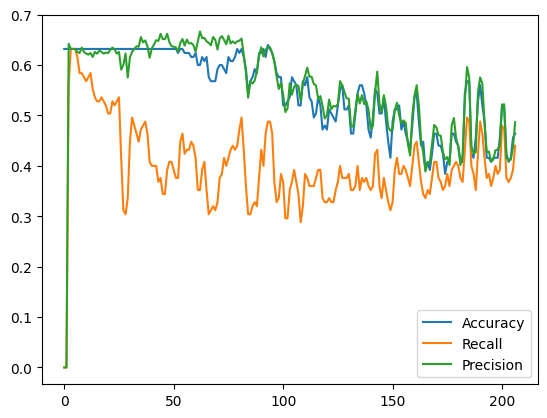

In [38]:
from sklearn.metrics import confusion_matrix


LSTM_model_final = tf.keras.models.load_model('./models/classification_mdl_wts.keras')

# evaluate final model
results_test = LSTM_model_final.evaluate(X_test_classification, Y_test_classification, batch_size=128, return_dict=True)
#Predict
y_prediction = LSTM_model_final.predict(X_test_classification)
y_prediction = np.argmax(y_prediction, axis = 1)
y_test=np.argmax(Y_test_classification, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction)
print(result)
print(LSTM_model_final.metrics_names)
print(results_test)
print(history.history["val_accuracy"])

plt.plot(range(len(history.history["val_accuracy"])), history.history["val_accuracy"], label="Accuracy")
plt.plot(range(len(history.history["val_recall"])), history.history["val_recall"],label="Recall")
plt.plot(range(len(history.history["val_precision"])), history.history["val_precision"], label="Precision")
#plt.plot(range(len(history.history["val_f1_score"])), history.history["val_f1_score"], label="$F_1$-Score")
plt.legend()
plt.savefig("./figures/classification_dl")


## Regression Model

In [19]:
# pip install bayesian-optimization
from bayes_opt import BayesianOptimization


# Bounded region of parameter space
pbounds = {
    'bs': (1, 1000),
    'lr': (0, 0.01),
    "lstm_units": (32, 512),
    "encoding_layers": (1, 4),
    "classification_layers": (1, 4),
    "dropout": (0, 0.6)
}


optimizer = BayesianOptimization(
    f=train_wrapper_regression,
    pbounds=pbounds,
    random_state=1,
)

optimizer.maximize(
    init_points=2,
    n_iter=30,
)

print(optimizer.max)

|   iter    |  target   |    bs     | classi... |  dropout  | encodi... |    lr     | lstm_u... |
-------------------------------------------------------------------------------------------------
| 1         | -0.227    | 417.6     | 3.161     | 6.862e-05 | 1.907     | 0.001468  | 76.32     |
| 2         | -0.4081   | 187.1     | 2.037     | 0.2381    | 2.616     | 0.004192  | 360.9     |
| 3         | -0.3922   | 420.4     | 1.176     | 0.4377    | 3.159     | 0.001316  | 70.54     |
| 4         | -0.3203   | 598.1     | 1.955     | 0.3978    | 2.345     | 0.001722  | 177.4     |
| 5         | -0.3389   | 897.3     | 2.589     | 0.0354    | 3.512     | 0.002269  | 120.9     |


KeyboardInterrupt: 

### Train final model

In [39]:
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

bs=1000
lr=0.01
lstm_units=32
encoding_layers=4
classification_layers=1
dropout=0.6


LSTM_model_final_reg = get_regression_model(encoding_layers, classification_layers, lstm_units, dropout)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=200,
    mode='min'
)

save_best_model = ModelCheckpoint(
    './models/regression_mdl_wts.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

LSTM_model_final_reg.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics=["mse", "mae"])
history = LSTM_model_final_reg.fit(
    x=X_train_regression, y=Y_train_regression,
    epochs=2000,
    batch_size=bs,
    validation_data=(X_validation_regression, Y_validation_regression),
    callbacks=[early_stopping, save_best_model]
)

Epoch 1/2000


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 54.1390 - mae: 7.3232 - mse: 54.1390 - val_loss: 30.0484 - val_mae: 5.4446 - val_mse: 30.0484
Epoch 2/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 32.1099 - mae: 5.6240 - mse: 32.1099 - val_loss: 16.4643 - val_mae: 4.0063 - val_mse: 16.4643
Epoch 3/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 17.4525 - mae: 4.1191 - mse: 17.4525 - val_loss: 7.2515 - val_mae: 2.6157 - val_mse: 7.2515
Epoch 4/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 8.3827 - mae: 2.8159 - mse: 8.3827 - val_loss: 2.4292 - val_mae: 1.4296 - val_mse: 2.4292
Epoch 5/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 3.3282 - mae: 1.7011 - mse: 3.3282 - val_loss: 0.6097 - val_mae: 0.6771 - val_mse: 0.6097
Epoch 6/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.8608 - mae: 0.7994 - mse: 0.8608 - val_loss: 0.6063 - val_mae: 0.6393 - val_mse: 0.6063
Epoch 7/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.5611 - mae: 0.6063 - mse: 0.5611 - val_loss:

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6922 - mae: 0.6338 - mse: 0.6922  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
MSE test: 0.640359129334507


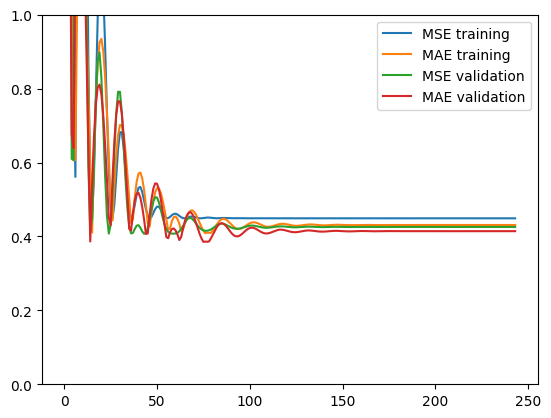

In [41]:
from sklearn.metrics import confusion_matrix


LSTM_model_final_reg = tf.keras.models.load_model('./models/regression_mdl_wts.keras')

# evaluate final model
results_test = LSTM_model_final_reg.evaluate(X_test_regression, Y_test_regression, batch_size=128)
#Predict
y_prediction = LSTM_model_final_reg.predict(X_test_regression)
print(f"MSE test: {((y_prediction - Y_test_regression)**2).mean()}")
#Create confusion matrix and normalizes it over predicted (columns)

plt.plot(range(len(history.history["mse"])), history.history["mse"], label="MSE training")
plt.plot(range(len(history.history["mae"])), history.history["mae"],label="MAE training")
plt.plot(range(len(history.history["val_mse"])), history.history["val_mse"], label="MSE validation")
plt.plot(range(len(history.history["val_mae"])), history.history["val_mae"],label="MAE validation")
plt.ylim((0,1))
plt.legend()
plt.savefig("./figures/regression_dl")


In [ ]:
def compile_and_fit(model, window, patience=30, bs=10, lr=0.01, max_epochs=30, regression=False):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  if not regression:
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics=["accuracy", "f1_score"])
  else:
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics=["mse", "mae"])
  X_train, Y_train = window.train
  X_test, Y_test = window.test
  history = model.fit(x=X_train, y=Y_train, epochs=max_epochs, batch_size=bs,
                      validation_data=(X_test, Y_test),
                      callbacks=[early_stopping])
  return history

## Beep model

In [ ]:
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

bs=1000
lr=0.01
lstm_units=32
encoding_layers=4
classification_layers=1
dropout=0.6


LSTM_model_final_beep = get_regression_model(encoding_layers, classification_layers, lstm_units, dropout)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=200,
    mode='min'
)

save_best_model = ModelCheckpoint(
    './models/beep_mdl_wts.hdf5',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

LSTM_model_final_beep.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics=["mse", "mae"])
history = LSTM_model_final_beep.fit(
    x=X_train_regression, y=Y_train_regression,
    epochs=2000,
    batch_size=bs,
    validation_data=(X_validation_regression, Y_validation_regression),
    callbacks=[early_stopping, save_best_model]
)

In [ ]:
from sklearn.metrics import confusion_matrix

# evaluate final model
results_test = LSTM_model_final_beep.evaluate(X_test_regression, Y_test_regression, batch_size=128)
#Predict
y_prediction = LSTM_model_final_beep.predict(X_test_classification)
y_prediction = np.argmax(y_prediction, axis = 1)
y_test=np.argmax(Y_test_regression, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
print(result)
print(results_test)

plt.plot(range(len(history.history["mse"])), history.history["mse"], label="MSE")
plt.plot(range(len(history["mae"])), history.history["mae"],label="MAE")

plt.show()
plt.savefig("./figures/beep_dl")
